# Functional network construction and cell ranking for in-vitro neuronal populations

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from skimage.feature import blob_dog

### Manual input parameters

In [4]:
expected_neuron_radius_pix = 5
dff_baseline_size = 300
dff_baseline_percent = 75
min_pk_height = 0.2

### Load image stack 


In [5]:
path = '../data/DFFtest.tif'
img = tiff.imread(path) # array of images (0-255): use img[index] to access a specific frame
img_array = np.array(img) # np array of coordinates/values
img_array = img_array / 255
# 1st dimension: image, 2nd dimension: row of image, 3rd dimension: col of image
frames, x_dim, y_dim = img_array.shape[0], img_array.shape[1], img_array.shape[2]

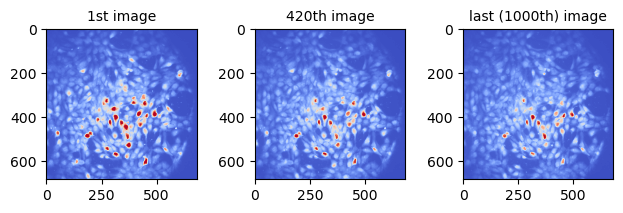

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.tight_layout()
ax1.set_title("1st image", fontsize=10)
ax1.imshow(img[0], cmap="coolwarm") 
ax2.set_title("420th image", fontsize=10)
ax2.imshow(img[419], cmap="coolwarm") 
ax3.set_title("last (1000th) image", fontsize=10)
ax3.imshow(img[999], cmap="coolwarm") 

In [6]:
mean_img = (np.mean(img_array, axis = 0))


Note: it is too computationally expensive to calculate the entire 682 x 682 standard deviation matrix at once (i.e. kernel crashes), so I calculated multiple sub-arrays and concatenated them in std_img for the full matrix

In [7]:
std1 = (np.std(img_array[:, :, : 200], axis = 0))

In [8]:
std2 = (np.std(img_array[:, :, 200 : 400 ], axis = 0))

In [9]:
std3 = (np.std(img_array[:, :, 400 : ], axis = 0))

In [10]:
std_img = np.concatenate((std1, std2, std3), axis=1)

### Measure variance of image

In [11]:
cv_img = std_img / mean_img # coefficient of variation or relative standard deviation
v2_mean_img = (std_img * std_img) / mean_img # variance to mean ratio
recip_img = mean_img / std_img # reciprocal ratio (SNR)
recip_sqimg = (mean_img / std_img) ** 2 # ^^ squared
eff_img = cv_img ** 2 # efficiency

/var/folders/_c/3ryrb96d5p152b08284fyjvm0000gn/T/ipykernel_5554/451648303.py:3: RuntimeWarning: divide by zero encountered in true_divide
  recip_img = mean_img / std_img # reciprocal ratio (SNR)
/var/folders/_c/3ryrb96d5p152b08284fyjvm0000gn/T/ipykernel_5554/451648303.py:4: RuntimeWarning: divide by zero encountered in true_divide
  recip_sqimg = (mean_img / std_img) ** 2 # ^^ squared


Plots

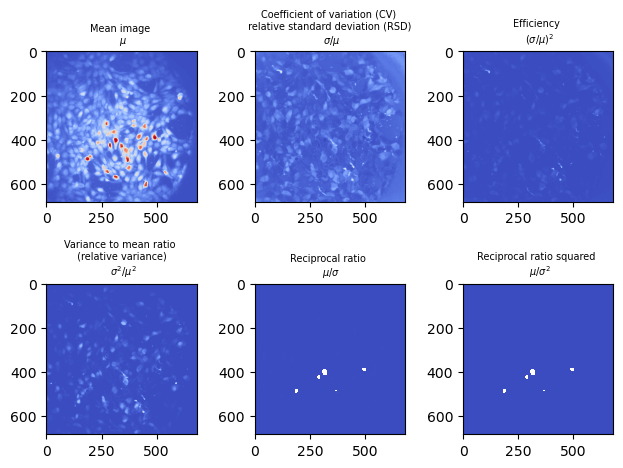

In [13]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
fig.tight_layout()

ax1.set_title("Mean image \n $\mu$", fontsize=7)
ax1.imshow(mean_img, cmap='coolwarm')

ax2.set_title("Coefficient of variation (CV) \n relative standard deviation (RSD) \n $\sigma / \mu$", fontsize=7)
ax2.imshow(cv_img, cmap='coolwarm')

ax3.set_title("Efficiency \n $(\sigma / \mu)^2$", fontsize=7)
ax3.imshow(eff_img, cmap='coolwarm')

ax4.set_title("Variance to mean ratio \n (relative variance) \n $\sigma^2 / \mu^2$", fontsize=7)
ax4.imshow(v2_mean_img, cmap='coolwarm')

ax5.set_title("Reciprocal ratio \n $\mu / \sigma$", fontsize=7)
ax5.imshow(recip_img, cmap='coolwarm')

ax6.set_title("Reciprocal ratio squared \n $\mu / \sigma^2$", fontsize=7)
ax6.imshow(recip_sqimg, cmap='coolwarm')

### Identify cell centers

Load from file

In [ ]:
# blobs_dog = '../data/insert_path_here'

Automatic (difference of gaussian)

In [15]:
blobs_dog = blob_dog(mean_img, min_sigma=7, max_sigma=10, threshold=0.005)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

In [27]:
xc = blobs_dog[:, 0]
yc = blobs_dog[:, 1]
num_neurons = blobs_dog.shape[0]

Plots

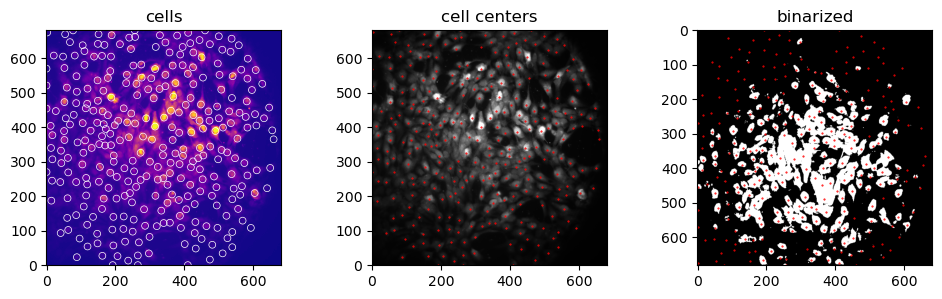

In [129]:


fig2, (ax, ax2, ax3) = plt.subplots(1, 3)
fig2.tight_layout()
fig2.set_figwidth(10)

# ax = plt.gca()
ax.set_title("cells")
ax.imshow(mean_img,origin='lower', cmap="plasma")
for cnt in range (0, len(blobs_dog)):
    c = plt.Circle((blobs_dog[cnt][1], blobs_dog[cnt][0]), blobs_dog[cnt][2], color='white', linewidth=0.5, fill=False)
    ax.add_patch(c)

ax2.imshow(mean_img,origin='lower', cmap="gray")
ax2.xlim=(0, 682)
ax2.ylim=(0, 682)
ax2.set_aspect('equal')
ax2.set_facecolor("black")
ax2.set_title("cell centers")
for i in range(0, len(blobs_dog)):
    ax2.plot(blobs_dog[i][1], blobs_dog[i][0], marker="o", c="red", markersize=0.5)

ax3.set_title("binarized")
ax3.imshow(mean_img > 0.2, cmap="gray")
for i in range(0, len(blobs_dog)):
    ax3.plot(blobs_dog[i][1], blobs_dog[i][0], marker="o", c="red", markersize=0.5)


### Extract fluorescence over time from a circle around selected cell coordinates; define cell-by-cell custon ROIs based on fluo

In [37]:
def extract_roibw(img, xc, yc, enrp):
    """
    PARAMS
    img (x dim, y dim): array for image
    xc, yc (# of cells): x and y coords of cell centers, respectively
    enrp (int): expected neuron radius pix

    RETURNS: 
    roi_bw: (# cells, x dim, y dim): isolate each cell by creating a binarized mask of each roi 
    """

    nn = len(xc) 
    x_dim = img.shape[1]
    y_dim = img.shape[2]
    r = np.zeros([nn, x_dim, y_dim]) 

    for i in range(nn):
        temp = np.zeros([x_dim, y_dim])
        for x in range(int(xc[i] - enrp), int(xc[i] + enrp)):
            for y in range(int(yc[i] - enrp), int(yc[i] + enrp)):
                if y < y_dim and y > 0 and x < x_dim and x > 0:
                    if np.sqrt((x - xc[i]) ** 2 + (y - yc[i]) ** 2) <= enrp: # if curr pixel is w/in radius dist from cell center
                        temp[x, y]= 1 # set to light (ie cell)
        r[i, :, :] = temp
                    
    return r

In [38]:
roibw = extract_roibw(img_array, xc, yc, expected_neuron_radius_pix)

In [42]:
def extract_raw_fluo(img, nn, roibw):
    """
    PARAMS
    img (x dim, y dim): np array of image
    nn (int): num neurons
    roibw (x dim, y dim): see above

    RETURNS: 
    raw_fluo (frames, # cells): raw fluorescent intensity over time; row = frame, col = cell
    """
    
    frames = img.shape[0] 

    r = np.zeros([frames, nn]) # each col is a cell's (change in) fluorescence over time

    for i in range(nn):

        # finding valid pixels
        rows, cols = [], [] # row + col indices for pixels w/ cells
        for index, px in np.ndenumerate(roibw[i, :, :]): # enumerate through the image in roibw for specified neuron
            if px == 1: # if cell exists there -> add to lists of saved rows + cols
                rows.append(index[0])
                cols.append(index[1])

        # taking average for each frame + adding to ret
        for fr in range(frames):
            avg_list = [] # fluo at each pixel w/ cell
            for j in range(len(rows)):
                avg_list.append(img[fr, rows[j], cols[j]]) 
            avg_fluo = np.mean(avg_list) # cell's overall fluo in that frame
            r[fr, i] = avg_fluo

    return r

In [44]:
raw_fluo = extract_raw_fluo(img_array, num_neurons, roibw)

### dF/F calculation

In [ ]:
def slide_win_sub(f, win_size, percent):
    """
    sliding window dff calculation: similar to raw fluo, but normalized --> shows "spiking"
    
    PARAMETERS
    f (frames, # of cells): raw fluorescence
    win_size: baseline window size
    percent: lower percent of baseline values to average

    RETURN
    dff: relative change in fluorescence in percent
    """
    
    num_rois = f.shape[1] # i.e. # of cells
    num_frames = f.shape[0]
    dff = np.zeros(f.shape())

    for i in range(0, num_rois):
        for j in range(0, num_frames):
            l_win = max(0, j - win_size)
            r_win = min(j + win_size)
            percent_win = np.floor(percent / 100 * (r_win - l_win))
            t_win = np.sort(f[i, l_win : r_win])
            f0 = np.mean(t_win[ : percent_win])
            dff[i, j] = (f[i][j] - f0) / f0

    return dff

In [ ]:
norm_f = raw_fluo / max(raw_fluo)
dff = slide_win_sub(norm_f, dff_baseline_size, dff_baseline_percent)
dff_active = np.zeros(dff.shape[0], dff.shape[1])

### Look for peaks (test)

### Correlation coefficient (test)

### Cross correlation (test)

### Distance matrix

### Plot dF/F and correlation matrix

### Get triangles

### Plot distance v correlation scatters

FUNCTION: binned mean

FUNCTION: scatter kernel density estimate

kernel density estimate

desu density scattercloud

### Histogram of correlation coefficient